Alexander S. Lundervold, October 18th, 2020

# Introduction

> ***This is extra material and not part of the course (in the sense that it won't be on the exam)***

## XGBoost

One of the most popular implementations of gradient boosting is XGBoost. In this notebook we'll see how to do hyperparamater optimization for XGBoost in an efficient way. This is meant both as an illustration of a more careful approach to hyperparameter optimization and to give you a practical tool you can use in your own explorations of machine learning (e.g. in assignment 2).

Scikit-learns's `GradientBoostingClassifier` and `GradientBoostingRegressor` can be used for gradient boosting. However, a more widely used implementation of gradient boosting is **XGBoost**: https://xgboost.readthedocs.io/en/latest (other common gradient boosters include LightGBM and CatBoost. Feel free to read about those here https://lightgbm.readthedocs.io/en/latest/index.html and here https://github.com/catboost/catboost) 

We won't go into details about how XGBoost works beyond what we've already covered in lectures. We'll rather play a bit with it on an example. 

You should consider reading more about the method here:
- https://xgboost.readthedocs.io/en/latest/tutorials/model.html
- http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting
- https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost
- https://campus.datacamp.com/courses/extreme-gradient-boosting-with-xgboost/classification-with-xgboost

We will see that XGBoost can be used through its Python API. We saw that you can use XGBoost essentially as if it was a Scikit-learn model. 

Using XGBoost without tuning its hyperparameters typically results in an underperforming model. 

> XGBoost depends heavily on careful choices of hyperparameters

In the notebook `DAT158-Part2-7-Extra-Hyperparameter_optimization.ipynb` we learned the basics of hyperparameters and how to tune them in scikit-learn by searching and cross-validation, using `GridSearchCV` and `RandomizedSearchCV`.

These also work for XGBoost, as we'll see below. However:

> XGBoost comes with its own powerful and efficient implementation of cross-validation!

# Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from pathlib import Path 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn

import seaborn as sns # For nicer plots

In [4]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

**Installing XGBoost**

In [5]:
import sys
!{sys.executable} -m pip install xgboost

# A test case: Hospital length of stay

We'll use the dataset studied in the previous notebook as our case study. 

In [6]:
NB_DIR = %pwd
NB_DIR = Path(NB_DIR)
DATA_DIR = NB_DIR/'localdata/rfexamples_data/'

In [7]:
# I've placed some data preparation code created in the previous notebook 
# in the function `prepare_hospital` in `utils.py`. Have a look if you're curious.
from utils import prepare_hospital

In [8]:
LOS = prepare_hospital(DATA_DIR/'LengthOfStay.csv')

In [9]:
DATA_DICT = pd.read_excel(DATA_DIR/'Data_Dictionary.xlsx')
METADATA = pd.read_csv(DATA_DIR/'MetaData_Facilities.csv')

In [10]:
LOS.head()

,rcount,gender,facid,eid,vdate,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,numberofissues,lengthofstay
0,0,0,1,1.0,2012-08-29,0.0,0.0,0.0,0.0,0.0,...,192.476913,12.0,1.390722,30.432417,96.0,6.5,4.0,2012-09-01,0.0,3.0
1,5,0,0,2.0,2012-05-26,0.0,0.0,0.0,0.0,0.0,...,94.078506,8.0,0.943164,28.460516,61.0,6.5,1.0,2012-06-02,0.0,7.0
2,1,0,1,3.0,2012-09-22,0.0,0.0,0.0,0.0,0.0,...,130.530518,12.0,1.065750,28.843811,64.0,6.5,2.0,2012-09-25,0.0,3.0
3,0,0,0,4.0,2012-08-09,0.0,0.0,0.0,0.0,0.0,...,163.377029,12.0,0.906862,27.959007,76.0,6.5,1.0,2012-08-10,0.0,1.0
4,0,0,4,5.0,2012-12-20,0.0,0.0,0.0,1.0,0.0,...,94.886658,11.5,1.242854,30.258926,67.0,5.6,2.0,2012-12-24,2.0,4.0


In [11]:
LOS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   rcount                      100000 non-null  int32         
 1   gender                      100000 non-null  int32         
 2   facid                       100000 non-null  int32         
 3   eid                         100000 non-null  float32       
 4   vdate                       100000 non-null  datetime64[ns]
 5   dialysisrenalendstage       100000 non-null  float32       
 6   asthma                      100000 non-null  float32       
 7   irondef                     100000 non-null  float32       
 8   pneum                       100000 non-null  float32       
 9   substancedependence         100000 non-null  float32       
 10  psychologicaldisordermajor  100000 non-null  float32       
 11  depress                     100000 non-n

## Dealing with dates

It seems reasonable that the day of week a patient is admitted to the hospital could influence the patient's length of stay (for example, if the patient is admitted just before the weekend). 

Let's add the day of week of the patient's visit as a feature, and drop the rest of the date information.

> This illustrates how you can use the `datetime` features of Pandas. Often very helpful when constructing models of phenomena with some kind of time dependence. 

In [12]:
LOS['vweekday'] = LOS['vdate'].dt.dayofweek

In [13]:
# We then drop the visit date (and also the date when the patient was discharged)
LOS.drop(['vdate', 'discharged'], axis=1, inplace=True)

In [14]:
LOS.head()

,rcount,gender,facid,eid,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,numberofissues,lengthofstay,vweekday
0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,192.476913,12.0,1.390722,30.432417,96.0,6.5,4.0,0.0,3.0,2
1,5,0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,94.078506,8.0,0.943164,28.460516,61.0,6.5,1.0,0.0,7.0,5
2,1,0,1,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,130.530518,12.0,1.065750,28.843811,64.0,6.5,2.0,0.0,3.0,5
3,0,0,0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,163.377029,12.0,0.906862,27.959007,76.0,6.5,1.0,0.0,1.0,3
4,0,0,4,5.0,0.0,0.0,0.0,1.0,0.0,1.0,...,94.886658,11.5,1.242854,30.258926,67.0,5.6,2.0,2.0,4.0,3


Notice that we have a new feature as our last column above.

## Prepare data for ML

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X = LOS.drop('lengthofstay', axis=1)
y = LOS['lengthofstay']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## Test a random forest

Just to make sure that things work, we train a random forest model on the data and measure its performance using average absolute error.

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

In [20]:
rf_reg.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [21]:
y_pred = rf_reg.predict(X_test)

In [22]:
from sklearn.metrics import mean_absolute_error

In [23]:
mean_absolute_error(y_test, y_pred)

0.33638099999999993

# XGBoost

We can use XGBoost through its Python API, essentially just as a scikit-learn model:

In [24]:
import xgboost as xgb
from xgboost import XGBRegressor

In [25]:
xgb_reg = XGBRegressor(n_jobs=-1, random_state=1)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
y_pred = xgb_reg.predict(X_test)

In [27]:
mean_absolute_error(y_test, y_pred)

0.30265415

This gives us a score that's not much better than the random forest above. **That is typical**: 
> to unlock XGBoost's potential you must tune its hyperparameters.

# Tuning XGBoost: the simple way
...which rarely works well in practice

All scikit-learn compatible models can be tuned by using `GridSearchCV` or `RandomizedSearchCV` over a specified parameter grid. 

In [28]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

We'll look more into the parameters of XGBoost below. For now, let's just list two parameter grids that often work okay-ish:

In [29]:
xgb_param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.0, 1.0, 1.5],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5, 6, 7, 8, 10]
        }


xgb_param_grid_large = {
        'learning_rate': [0.1, 0.05, 0.2],
        'n_estimators': [50, 100, 500, 600],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.0, 1.0, 1.5],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.5, 0.6, 0.8],
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        }

A complete grid search over all of these combinations only works if you either have a small data set or a lot of time available. 

A random search, where you simply try a set number of different combinations at random, can sometimes produce improved models, depending on how many iterations you have time for. 

Let's try it out:

In [30]:
xgb_reg = XGBRegressor(random_state=42)

In [31]:
r_xgb_reg = RandomizedSearchCV(xgb_reg, xgb_param_grid, n_iter=50, verbose=1, n_jobs=-1, cv=3, random_state=42)

In [32]:
%%time
r_xgb_reg.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.5min finished


Wall time: 4min 33s


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          num_parallel_tree=None,
                                          random_state=42, reg_alpha=None,
                                          reg_lam

In [33]:
r_xgb_reg.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
y_pred = r_xgb_reg.predict(X_test)

In [35]:
mean_absolute_error(y_test, y_pred)

0.30751166

# Tuning XGBoost the XGBoost way

Since you rarely have the time to grid search through a large set of parameters, and random search is pretty unpredictable, it's typically better to go about things in a more careful manner. 

## DMatrix

When using the native XGBoost API we have to convert our data to the **DMatrix** format, an <a href="https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.core">internal data structure</a> in XGBoost that is optimized for both memory efficiency and training speed. 

In [36]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## A quick overview of XGBoost parameters

We'll only look at some of the basics. For more details about XGBoost and its parameters I recommend 

1. https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
2. https://www.slideshare.net/ShangxuanZhang/kaggle-winning-solution-xgboost-algorithm-let-us-learn-from-its-author
3. https://xgboost.readthedocs.io/en/latest/parameter.html

We'll follow the first reference quite closely below.

In [37]:
#?XGBRegressor

The main parameters to consider are:

- `num_boost_round`, which controls the number of trees to build, and `early_stopping_rounds`, a parameter that enables us to stop adding trees once we've reached a good number. 

XGBoost provides and automatic way of finding these parameters by monitoring the performance during training. You simply test whether each tree added to the ensemble improves performance. Once `early_stopping_rounds` number of trees have been added without performance increase, you stop training and store the best number of trees in `num_boost_rounds`. 

This value depends on all the other hyperparameter settings so it's best to calculate it every time a parameter is updated.

Other parameters can be found using the **cross-validation** function of XGBoost:

- `max_depth`, `min_child_weigth` and `gamma`, which control the **model complexity** by constraining it. The first two are similar to the ones in random forests, while `gamma` is the minimum loss reduction we allow to further partition a leaf node. The default value 0.0 for `gamma` is usually okay, which let's the algorithm split a node as long as it gives any reduction in the loss function. 


- `subsample`, `colsample_bytree`, which controls how the model samples the training data each round. What fraction of training examples to sample from, and what fraction of features to use. If both are set to 0.5, for example, then XGBoost will randomly sample half the training data and half the features before growing trees. The randomness introduced by this helps make the model more robust to noise in the data, reducing overfitting. 


- `learning_rate` controls how much each round corrects the errors of the previous round ("residual learning"). It's usually okay to use the default 0.1. 

There are other typically less influental parameters as well (have a look at the documentation for a complete list). For example `lambda`, which controls the amount of L2 regularization, and `alpha`, which controls the amount of L1 regularization. We won't tune these.

## `xgb.cv`

Cross validation the native XGBoost way:

<img src="assets/K-fold_cross_validation_EN.jpg">

We start by setting up a parameter dictionary with some starting values for the parameters we want to tune:

In [38]:
params = {
    'max_depth': 8,
    'min_child_weight': 10,
    'subsample': 1,
    'colsample_bytree': 0.8,
}

...and add the evaluation metric we'll use to decide on the optimal number of trees:

In [39]:
params['eval_metric'] = 'mae' # Mean absolute error

... and a high number for the trees, which we'll reduce using early stopping:

In [40]:
num_boost_round = 1500

We'll stop training the model after 10 rounds with no decrease in the validation error. This is to combat overfitting. 

In [41]:
early_stopping_rounds = 10

Let's check how our current parameters perform in cross-validation. **WARNING**: This takes a while...

In [42]:
%%capture
# Added capture to suppress the output (try without to see what happens)
cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, 
                    early_stopping_rounds=early_stopping_rounds, nfold=3, metrics='mae', 
                    stratified=True, seed=42)

Here are the last few scores:

In [43]:
cv_results[-25:]

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
93,0.225110,0.001168,0.318262,0.001783
94,0.224738,0.001214,0.318283,0.001767
95,0.224436,0.001236,0.318304,0.001771
96,0.224095,0.001009,0.318332,0.001814
97,0.223912,0.000965,0.318355,0.001828
98,0.223263,0.001340,0.318373,0.001834
99,0.222752,0.001152,0.318307,0.001804
100,0.222190,0.000900,0.318217,0.001659
101,0.221850,0.000600,0.318210,0.001633
102,0.221308,0.000548,0.318233,0.001643


The best score is:

In [44]:
cv_results['test-mae-mean'].min()

0.31761700000000004

in round 

In [45]:
cv_results['test-mae-mean'].values.argmin()

117

This is the score we can get with our baseline parameters and an optimal number of trees added. 

The next step is to find a good setting for `max_depth` and `min_child_length`. Then, using these values, find good settings for `subsample` and `colsample_by_tree`.

## Finding `max_depth` and `min_child_weight`:

Remember that we stored the default parameters in `params`:

In [46]:
params

{'max_depth': 8,
 'min_child_weight': 10,
 'subsample': 1,
 'colsample_bytree': 0.8,
 'eval_metric': 'mae'}

We'll update these parameters if we find something better. 

We'll set up a small parameter grid for `max_depth` and `min_child_weight` in which we expect to find some good settings. **Note:** The values you should choose here depends on the data. I recommend using a larger grid if possible, but I kept it relatively small here to reduce computation time. 

In [47]:
complexity_params = {
    'max_depth': range(5,8),
    'min_child_weight': range(1,7)
}

We turn it into a scikit-learn parameter grid, for convenience:

In [48]:
from sklearn.model_selection import ParameterGrid

complexity_param_grid = ParameterGrid(complexity_params)

We're going to search through all these combinations looking for the best one, all the time using early stopping to get the best number of trees (boosting rounds) automatically:

In [49]:
# Intial best parameters
min_mae = float("Inf")
best_params = None

This will take a while..

In [50]:
%%capture
# Code based on https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
for current_params in complexity_param_grid:
    
    # Current settings
    md = current_params['max_depth']
    mcw = current_params['min_child_weight']
    
    
    # Use the current parameter settings
    params['max_depth'] = md
    params['min_child_weight'] = mcw
    
    # And evaluate them using cross-validation
    cv_results = xgb.cv(
        params, dtrain, num_boost_round=num_boost_round, early_stopping_rounds=early_stopping_rounds, 
        stratified=True, seed=42, nfold=3, metrics='mae'
    )
    
    # If the score improved, we update the current best parameters:
    mean_mae = cv_results['test-mae-mean'].min()
    
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (md, mcw)

In [51]:
print(f'Best parameters are: {best_params}, which gave a MAE of {min_mae}')

Best parameters are: (5, 2), which gave a MAE of 0.310372


Let's update our parameter settings to reflect this:

In [52]:
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

...and continue to the next stage

## Finding `subsample` and `colsample_bytree`

In [53]:
sampling_params = {
    'subsample': [i/10. for i in range(8,11)],
    'colsample_bytree': [i/10. for i in range(3,11)]
}

In [54]:
sampling_param_grid = ParameterGrid(sampling_params)

In [55]:
min_mae = float("Inf")
best_params = None

In [56]:
%%capture
for current_params in sampling_param_grid:
    
    # Current settings
    ss = current_params['subsample']
    csbt = current_params['colsample_bytree']
    
    # Use the current parameter settings
    params['subsample'] = ss
    params['colsample_bytree'] = csbt
    
    # And evaluate them using cross-validation
    cv_results = xgb.cv(
        params, dtrain, num_boost_round=num_boost_round, early_stopping_rounds=early_stopping_rounds, 
        stratified=True, seed=42, nfold=3, metrics='mae'
    )
    
    # If the score improved, we update the current best parameters:
    mean_mae = cv_results['test-mae-mean'].min()
    
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (ss, csbt)

In [57]:
print(f'Best parameters are: {best_params}, which gave a MAE of {min_mae}')

Best parameters are: (1.0, 1.0), which gave a MAE of 0.30814800000000003


We update our current best parameter settings:

In [58]:
params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

...and continue to the final stage with our current best parameters, which are:

In [59]:
params

{'max_depth': 5,
 'min_child_weight': 2,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'eval_metric': 'mae'}

## Finding `num_boost_rounds`

The final step is to decide on a good number of trees to use, given our current parameters.

As this is not done using cross-validation, we to create a hold-out validation set for this:

In [60]:
X_train_num_boost, X_val_num_boost, y_train_num_boost, y_val_num_boost = train_test_split(X_train, 
                                                                                           y_train, 
                                                                                           stratify=y_train, 
                                                                                           random_state=42)

In [61]:
dtrain_num_boost = xgb.DMatrix(X_train_num_boost, label=y_train_num_boost)
dval_num_boost = xgb.DMatrix(X_val_num_boost, label=y_val_num_boost)

In [62]:
early_stopping_rounds=10

In [63]:
%%capture
model = xgb.train(
    params,
    dtrain_num_boost,
    num_boost_round=num_boost_round,
    evals=[(dval_num_boost, "Validation")],
    early_stopping_rounds=early_stopping_rounds
)

The best iteration and test score is: 

In [64]:
print(f'Best iteration: {model.best_iteration}, Best score: {model.best_score}')

Best iteration: 118, Best score: 0.31216


`num_boost_round` set to this therefore seems like a good choice. 

In [65]:
num_boost_round = model.best_iteration

## Summary

The final parameter settings that gave us the best result are:

In [66]:
params

{'max_depth': 5,
 'min_child_weight': 2,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'eval_metric': 'mae'}

In [67]:
num_boost_round

118

We can train a model using these parameter and test it on the test set:

In [68]:
%%capture
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
)

In [69]:
y_pred = model.predict(dtest)

In [70]:
mean_absolute_error(y_test, y_pred)

0.30404815

## Feature importances

As always, it's fun/interesting to have a look at feature importances (and permutation importances). But remember to not read too much into this for all the reasons discussed earlier in the course.

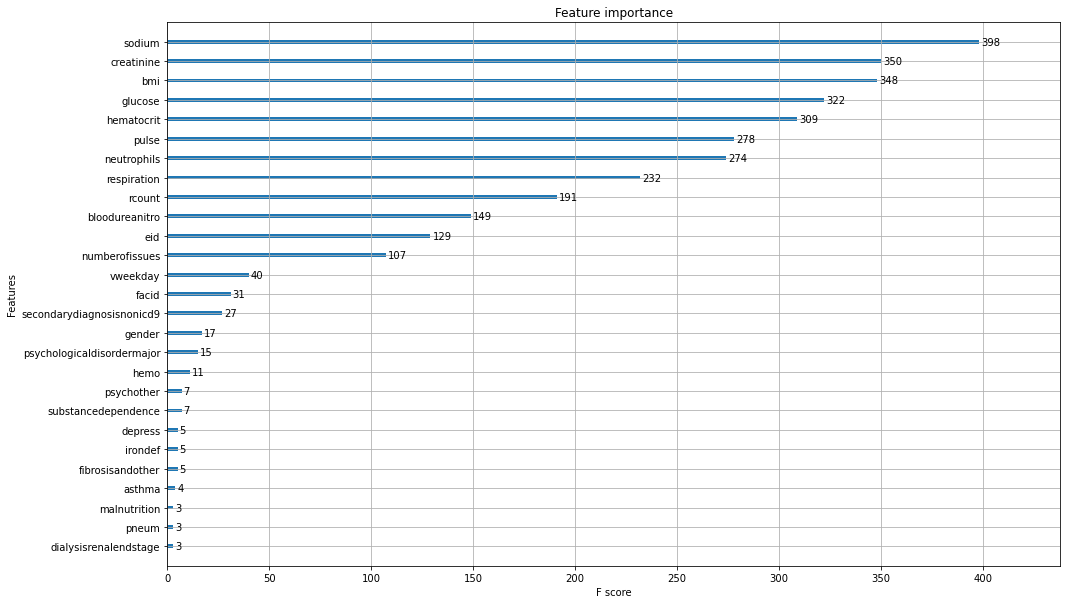

In [71]:
fig, ax = plt.subplots(figsize=(16,10))
xgb.plot_importance(model, ax=ax)
plt.show()

# How to improve this

A simple way to improve the scores is to search over bigger parameter spaces (at the price of increased computation time). 

There are also many practical introductions to hyperparameter optimization for XGBoost that goes into more details. For example:

- https://www.slideshare.net/odsc/owen-zhangopen-sourcetoolsanddscompetitions1
- https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- https://www.datacamp.com/courses/extreme-gradient-boosting-with-xgboost
- https://www.slideshare.net/ShangxuanZhang/kaggle-winning-solution-xgboost-algorithm-let-us-learn-from-its-author
- https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
- https://stats.stackexchange.com/questions/243908/tuning-order-xgboost

# Your turn!

## Your turn #1:

Try optimizing the `gamma` as well. This should be done after `max_depth` and `min_child_weight`, and before `subsample` and `colsample_bytree`.

Some good values to try are:

In [72]:
gamma_params = {
    'gamma': [i/10. for i in range(0,5)]
}

## Your turn #2:
Try this out on a different data set! For example the one you used in Assignment 2, or the housing prices data set from Assignment 1. 

If you follow the steps above carefully, making some slight changes to the values tested if necessary, you should be able to get a model that outperforms your previous models. 